In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
loaded = False

# Load BioBank Components

In [4]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    biobank_data_no_HLA_alleles, biobank_index, med_code_mapping = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True
    HLA_alleles = data_tools.load_HLA_data()
    biobank_data = biobank_data_no_HLA_alleles.merge(HLA_alleles, how="left", on="eid")

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 376 features.
UK BioBank Data Loaded.
Size: 502536 rows x 376 columns
Elapsed time: 62.6501 seconds


Mapping Medical Codes:   0%|          | 0/361 [00:00<?, ? feature/s]

 # Basic Summary stats

In [5]:
cancer_data = biobank_data.loc[~biobank_data["cancer_code"].isna()].copy(deep=True)

In [6]:
variables_of_interest = ["sex", "cancer_code"]

grouping_df = cancer_data[variables_of_interest].copy(deep=True)
grouping_df["total"] = grouping_df["sex"] != "nothing"
grouping_df["female"] = grouping_df["sex"] == "Female"
grouping_df["male"] = grouping_df["sex"] == "Male"
grouping_df = grouping_df.groupby("cancer_code").sum().reset_index()

grouping_df = grouping_df.loc[ ~grouping_df["cancer_code"].isin(constants.SEX_SPECIFIC_CANCERS)]
grouping_df = grouping_df.query("total > 5").sort_values("total", ascending=False)
most_common_cancers = grouping_df["cancer_code"]

grouping_df["male_fraction"] = grouping_df["male"] / grouping_df["total"]
grouping_df["female_fraction"] = grouping_df["female"] / grouping_df["total"]
grouping_df

,cancer_code,total,female,male,male_fraction,female_fraction
4,basal cell carcinoma,4064,2402,1662,0.408957,0.591043
34,malignant melanoma,3477,2072,1405,0.404084,0.595916
14,colon cancer/sigmoid cancer,1472,624,848,0.576087,0.423913
64,skin cancer,1354,680,674,0.497784,0.502216
5,bladder cancer,1049,278,771,0.734986,0.265014
...,...,...,...,...,...,...
3,appendix cancer,13,8,5,0.384615,0.615385
71,thymus cancer / malignant thymoma,10,5,5,0.500000,0.500000
55,peripheral nerve/autonomic nerve cancer,10,4,6,0.600000,0.400000
37,metastatic cancer (unknown primary),9,6,3,0.333333,0.666667


# Example Plot

/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


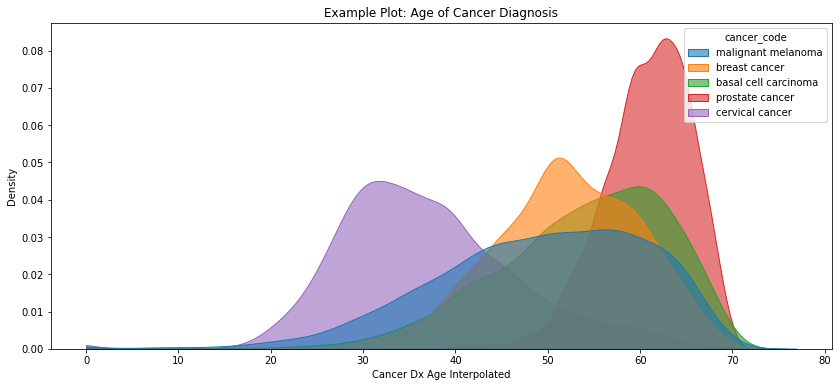

In [7]:
cancer_codes, counts = np.unique(cancer_data["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[np.argsort(counts,)[-5:]]
common_cancer_data = cancer_data.loc[cancer_data["cancer_code"].isin(common_cancer_codes)]

fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_data, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax,
            cumulative=False, shade=True, common_norm=False, bw=.2, alpha=.6, clip=[0, None])
ax.set_title("Example Plot: Age of Cancer Diagnosis")
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_dx_age.png"), facecolor="#fffffe")

<ipython-input-8-c2c4216e7257>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


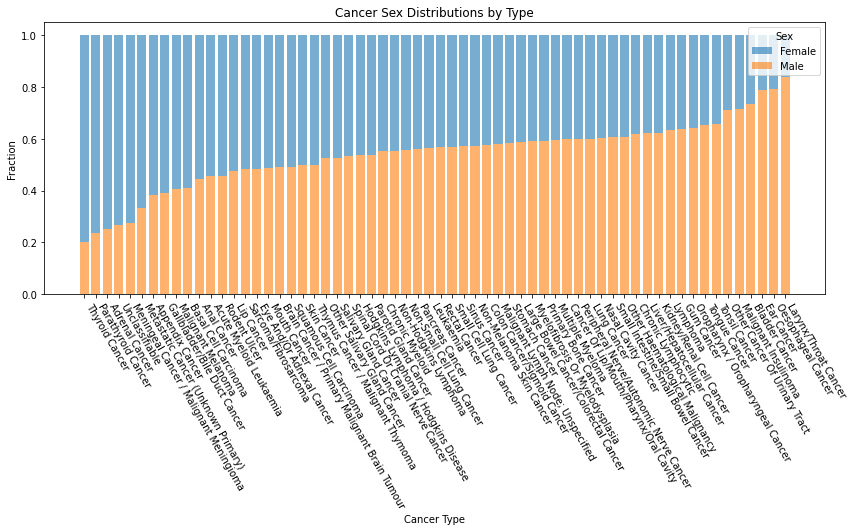

In [8]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("male_fraction")
ax.bar(data=data, x="cancer_code", height="female_fraction",
       bottom="male_fraction", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male_fraction", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Fraction")
ax.legend(title="Sex")
ax.set_title("Cancer Sex Distributions by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

<ipython-input-9-49192d3d31ca>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


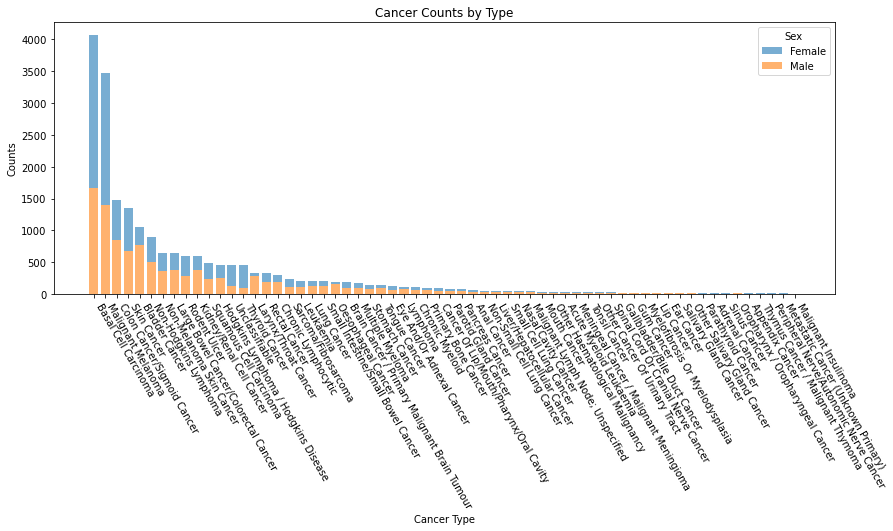

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("total", ascending=False)

ax.bar(data=data, x="cancer_code", height="female", bottom="male", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Counts")
ax.legend(title="Sex")
ax.set_title("Cancer Counts by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

Text(0.5, 1.0, 'Cancer Age Distributions')

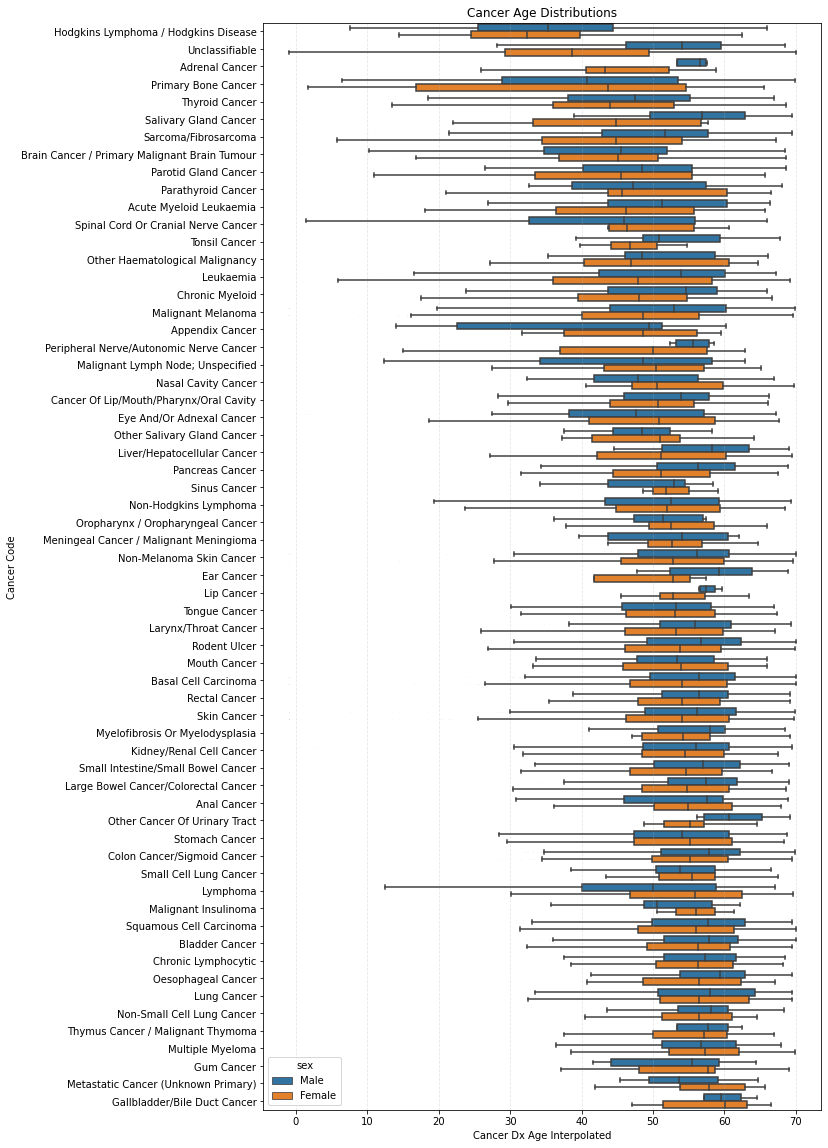

In [10]:
fig, ax = plt.subplots(figsize=(10, 20))
data = cancer_data.loc[cancer_data["cancer_code"].isin(most_common_cancers)].copy(deep=True)

sort_df = data.query("sex == 'Female'")[["cancer_dx_age_interpolated", "cancer_code"]
                                     ].groupby("cancer_code").median().reset_index()
sort_dict = dict(zip(sort_df["cancer_code"], sort_df["cancer_dx_age_interpolated"]))
sort_function = lambda key: sort_dict[key]
sort_function = np.vectorize(sort_function)

data["sort"] = data["cancer_code"].apply(sort_function)
data = data.sort_values("sort")

y, x = "cancer_code", "cancer_dx_age_interpolated"
sns.boxplot(data=data, x=x, y=y, hue="sex", ax=ax, orient="h", fliersize=.01)
ax.xaxis.grid(True, alpha=.3, linestyle="--", zorder=-10)

ax.set_yticklabels([t._text.title() for t in ax.get_yticklabels()]);
add_plt_labels(ax, x=x, y=y)
ax.set_title("Cancer Age Distributions")

In [11]:
from utilities import *

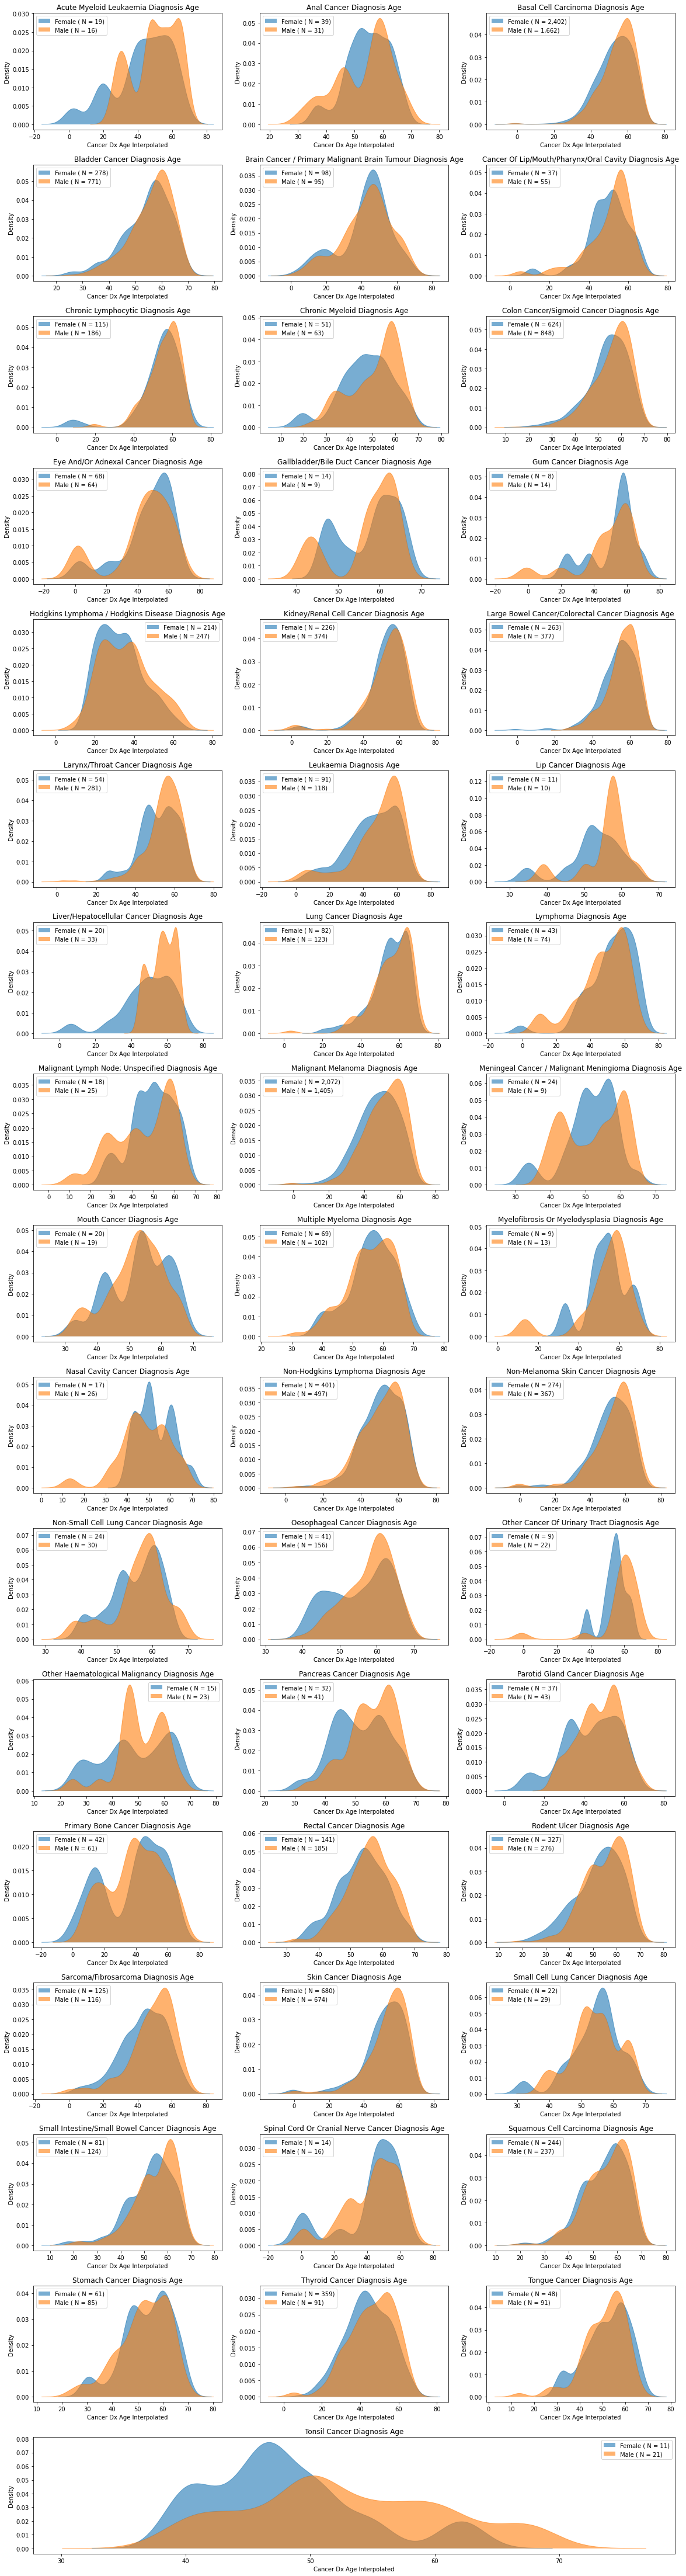

In [12]:
x, y, hue = "cancer_dx_age_interpolated", "density", "sex"

cancer_types = exclude(sorted(cancer_data["cancer_code"].unique()), constants.SEX_SPECIFIC_CANCERS)

plot_cancer_types = []
for cancer_type in cancer_types:
    data = cancer_data.query(f"cancer_code == '{cancer_type}'")
    counts = np.unique(data[hue], return_counts=True)[1]

    if len(data) > 20 and len(counts) > 1:
        plot_cancer_types.append(cancer_type)

fig, axes = create_subplot(len(plot_cancer_types), ncols=3, height_per=3)

for ax, cancer_code in zip(axes, plot_cancer_types):
    data = cancer_data.query(f"cancer_code == '{cancer_code}'")
    kde_plot(data=data, x=x, hue=hue, ax=ax, bw=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_code.title()} Diagnosis Age")

# Viral Specific Exploration

In [15]:
viral_cancer_types = [
    'hodgkins lymphoma / hodgkins disease', 'larynx/throat cancer', 'stomach cancer',
    'anal cancer', 'liver/hepatocellular cancer',
    'cancer of lip/mouth/pharynx/oral cavity',
    'nasal cavity cancer', 'kaposis sarcoma'
]

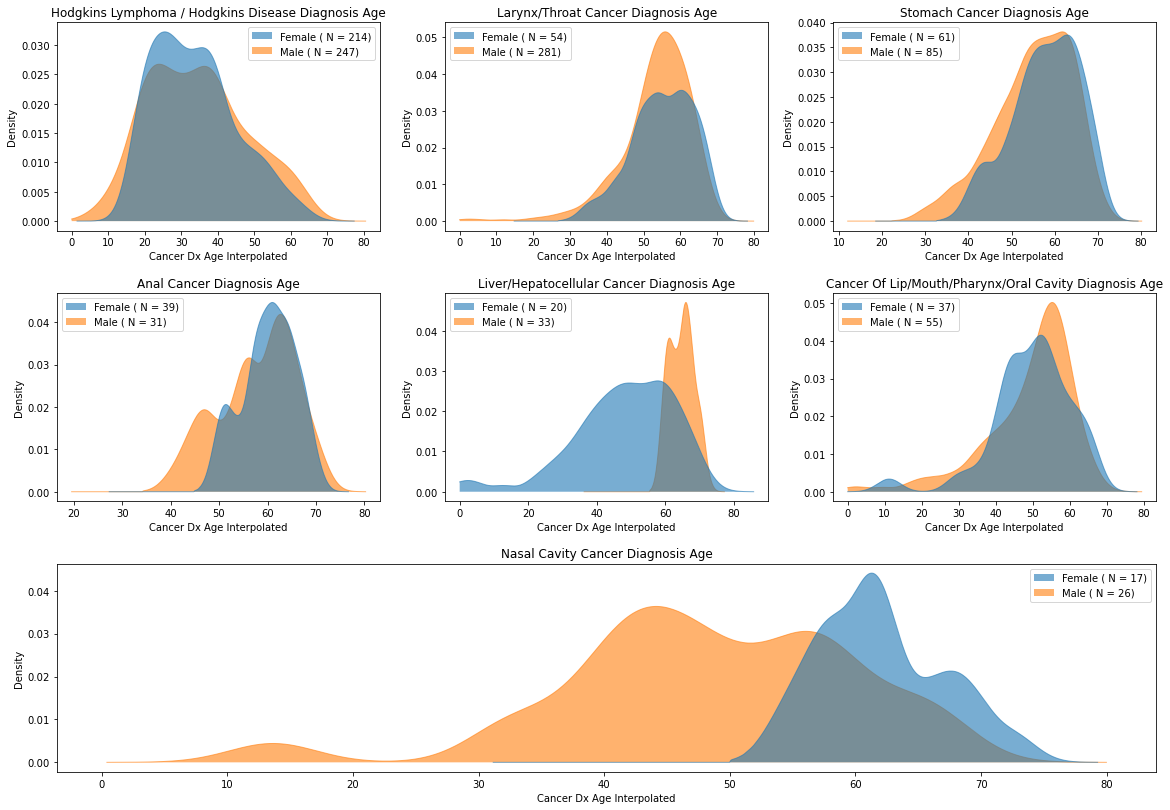

In [18]:
x, y, hue = "cancer_dx_age_interpolated", "density", "sex"


fig, axes = create_subplot(len(viral_cancer_types), ncols=3, height_per=3)

for ax, cancer_code in zip(axes, viral_cancer_types):
    data = cancer_data.query(f"cancer_code == '{cancer_code}'")
    kde_plot(data=data, x=x, hue=hue, ax=ax, bw=.3, clip=[0, None])
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_code.title()} Diagnosis Age")

In [131]:
from analysis import *

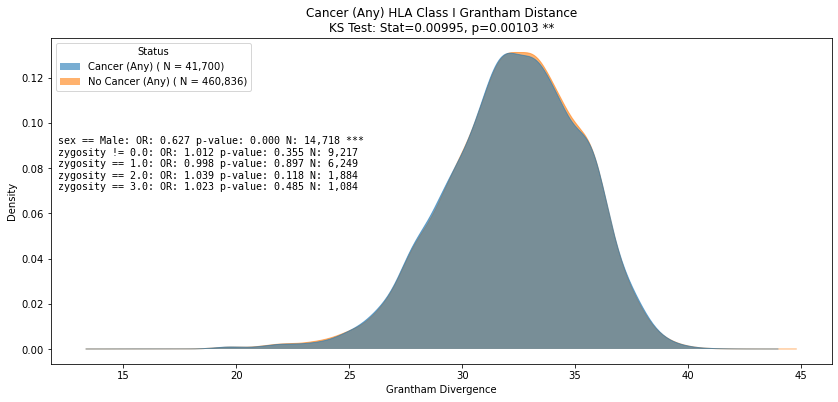

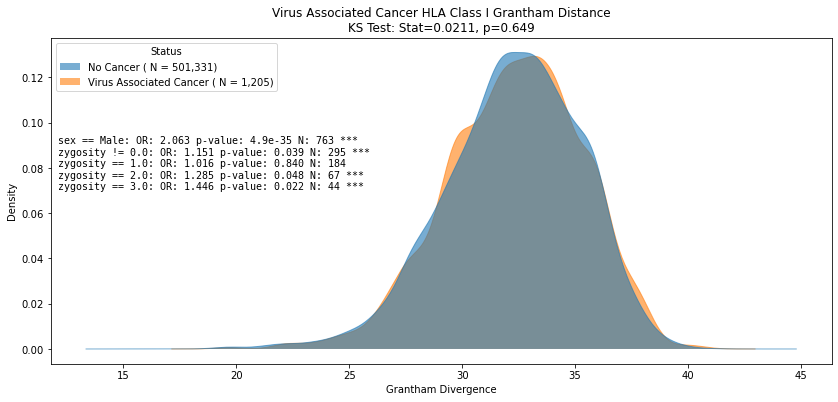

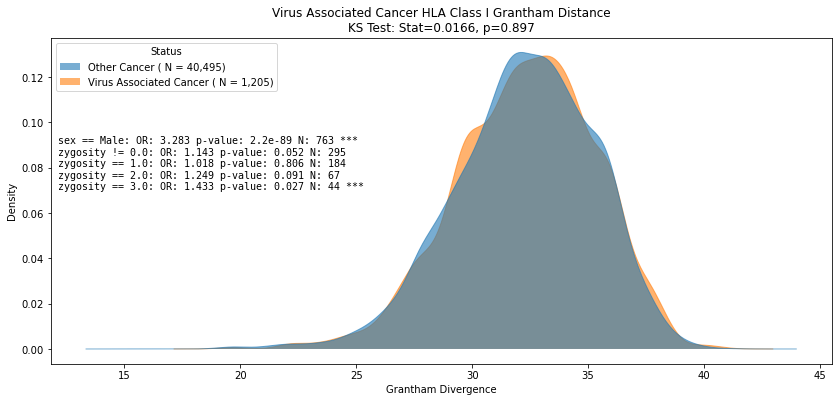

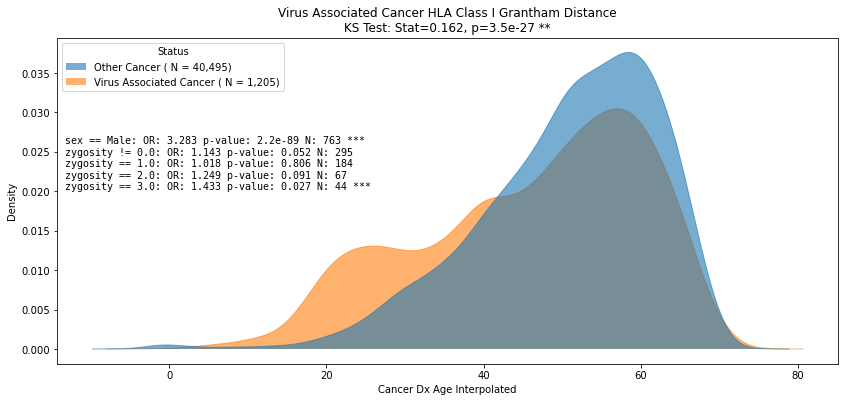

In [211]:
fig, ax = plt.subplots(figsize=(14, 6))
variable_OR_plot(biobank_data, "cancer (any)", ~biobank_data["cancer_code"].isna(),
                 OR_variable=["sex", "zygosity"], ax=ax)
fig.savefig(f"cancer_EDA_plots/HLA_grantham_distance_all_cancers.png")


fig, ax = plt.subplots(figsize=(14, 6))
variable_OR_plot(biobank_data, "virus associated cancer", biobank_data["cancer_code"].isin(viral_cancer_types),
                 OR_variable=["sex", "zygosity"], ax=ax, no_illness_label="no cancer")
fig.savefig(f"cancer_EDA_plots/HLA_grantham_distance_virus_associated.png")

fig, ax = plt.subplots(figsize=(14, 6))
variable_OR_plot(cancer_data, "virus associated cancer", cancer_data["cancer_code"].isin(viral_cancer_types),
                 OR_variable=["sex", "zygosity"], ax=ax, no_illness_label="other cancer")
fig.savefig(f"cancer_EDA_plots/HLA_grantham_distance_virus_associated.png")

fig, ax = plt.subplots(figsize=(14, 6))
variable_OR_plot(cancer_data, "virus associated cancer", cancer_data["cancer_code"].isin(viral_cancer_types),
                 OR_variable=["sex", "zygosity"], ax=ax, x="cancer_dx_age_interpolated",
                 no_illness_label="other cancer")
fig.savefig(f"cancer_EDA_plots/cancer_dx_age_virus_associated.png")

In [216]:
x = "grantham_divergence"
OR_variables = ["sex", "zygosity"]

for cancer_code in tqdm(viral_cancer_types):
    fig, ax = variable_OR_plot(biobank_data, cancer_code, "cancer_code", x=x, OR_variable=OR_variables)
    save_name = cancer_code.replace(" ", "_").replace("/", "_")
    fig.savefig(f"cancer_EDA_plots/grantham_distance_plots/HLA_grantham_distance_{save_name}.png")
    plt.close()

100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


 88%|████████▊ | 7/8 [00:04<00:00,  1.50it/s]


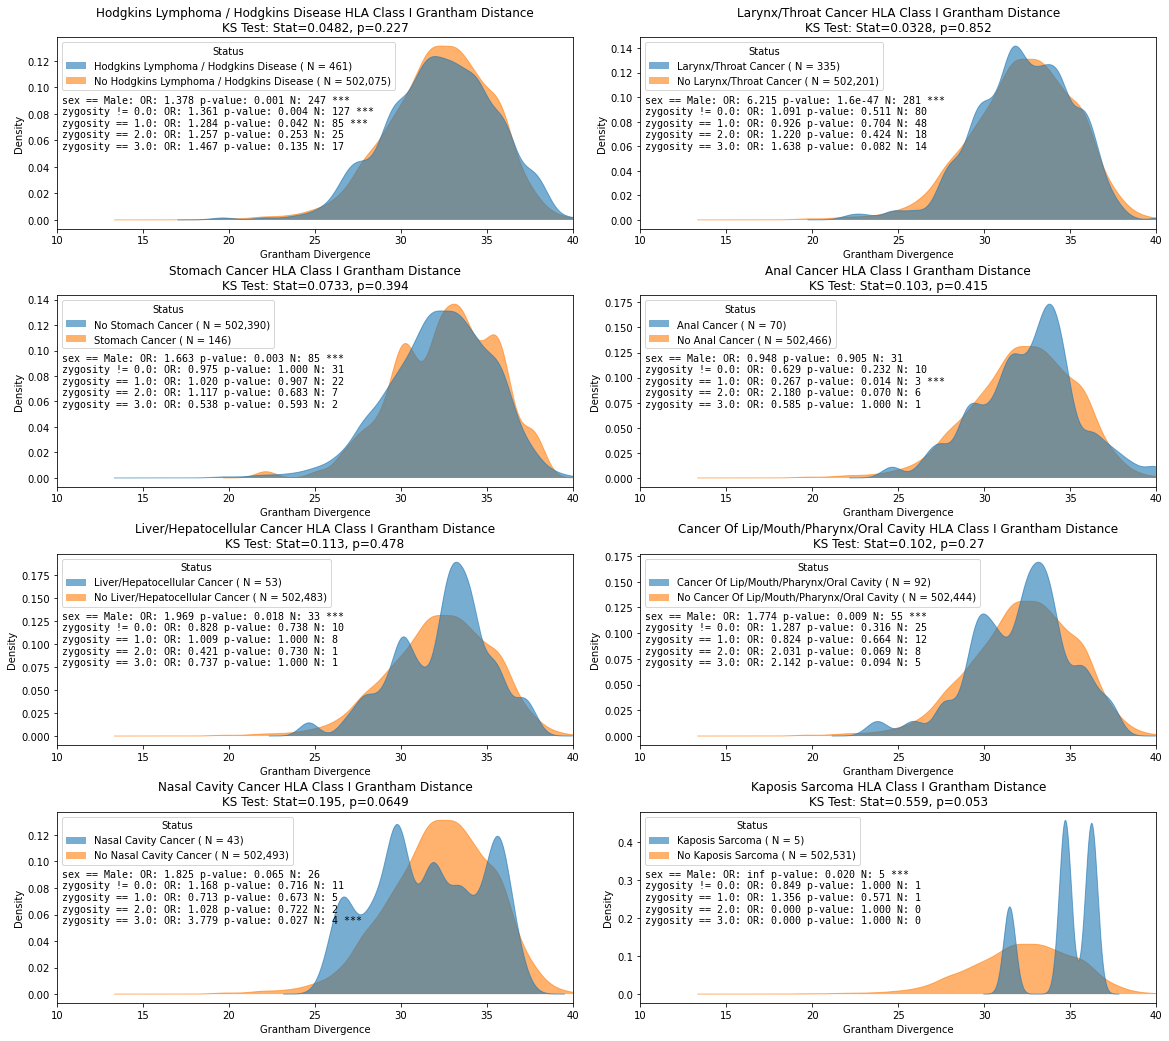

In [217]:
fig, axes = create_subplot(len(viral_cancer_types), ncols=2, height_per=3, wspace=.13, hspace=.35)

for ax, cancer_code in zip(axes, tqdm(viral_cancer_types)):
    variable_OR_plot(biobank_data, cancer_code, "cancer_code", x=x, OR_variable=OR_variables, ax=ax)
    ax.set_xlim(10, 40)

fig.savefig(f"cancer_EDA_plots/grantham_distance_plots/HLA_grantham_distance_virus_associated_all.png")

 88%|████████▊ | 7/8 [00:00<00:00, 15.57it/s]


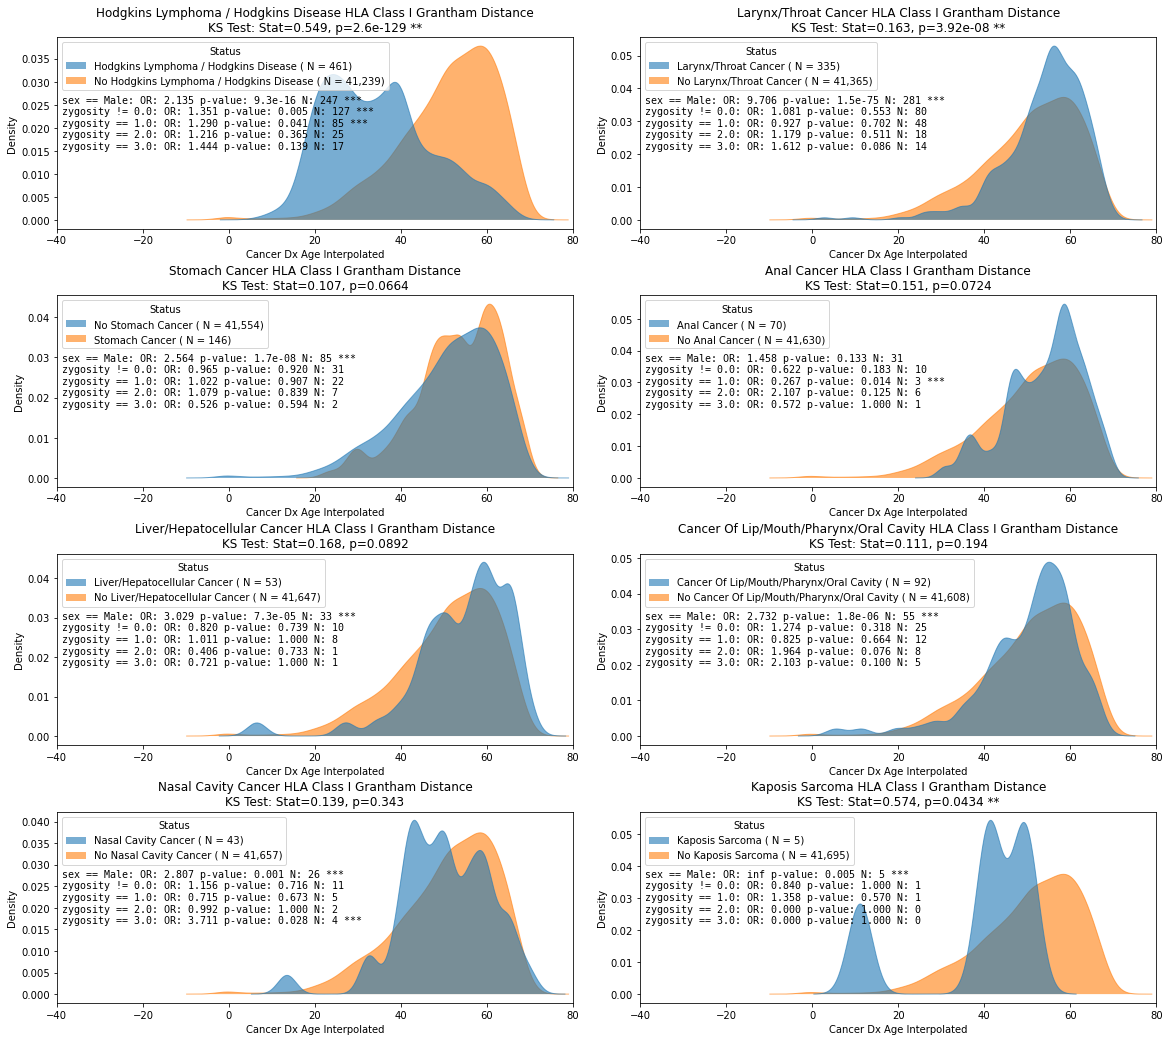

In [223]:
x = "cancer_dx_age_interpolated"

fig, axes = create_subplot(len(viral_cancer_types), ncols=2, height_per=3, wspace=.13, hspace=.35)
for ax, cancer_code in zip(axes, tqdm(viral_cancer_types)):
    variable_OR_plot(cancer_data, cancer_code, "cancer_code", x=x, OR_variable=OR_variables, ax=ax)
    ax.set_xlim(-40, 80)
fig.savefig(f"cancer_EDA_plots/cancer_dx_age_virus_associated_all.png")